<a href="https://colab.research.google.com/github/asimthaha/Pytorch_fundamentals/blob/main/02_Pytorch_neural_network_classsification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification

* Binary
* Multiclass
* Multi label

## Make Classification data and getting it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
# make 1000 samples
n_samples = 1000

# create circles
X, Y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

len(X), len(Y)

(1000, 1000)

In [3]:
print(f"First five samples of X: \n {X[:5]}")
print(f"First five samples of Y: \n {Y[:5]}")

First five samples of X: 
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five samples of Y: 
 [1 1 1 1 0]


In [4]:
# make dataframe of circles
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                       "label":Y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


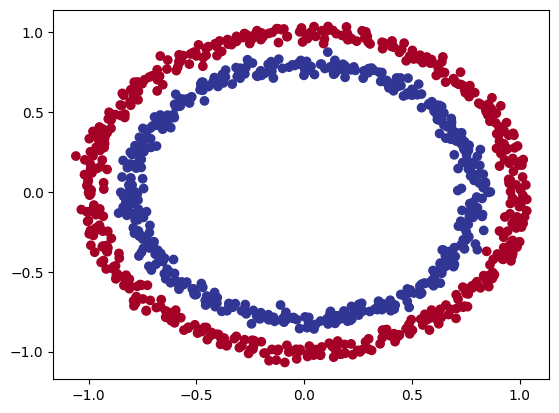

In [5]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=Y,
            cmap=plt.cm.RdYlBu)

Note: the data we are working with is called as a toy dataset, which is enough to experiment.

### 1.1 Check input and output shapes



In [6]:
X.shape, Y.shape

((1000, 2), (1000,))

In [7]:
# view the first example of features and labels
X_sample = X[0]
Y_sample = Y[0]

# we have two feature sof X trying to predict one Y

### 1.2 Turning data into tensors and create train and test splits

In [8]:
# turn out data into tensors, now its a numpy array
import torch

In [9]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [10]:
X=torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

X[:5], Y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
# split the data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,
                                                    test_size=0.2,
                                                    random_state=42)

In [12]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(800, 200, 800, 200)

## 2. Building a Model
to classify our blue and red dots

1. setup device agnostic code
2. Construct a model subclassing nn.Module
3. Define loss function and optimizer
4. Create a training and testing loop

### 2.1 Device Agnostic code

In [26]:
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

### 2.2 Creating out model
1. nn.Module
2. nn.Linear()
3. forward()
4. create an instance of our model

In [28]:
# 1.
class CircleModel(nn.Module):
  # 2.
  def __init__(self):
    super().__init__()
    self.layer1= nn.Linear(in_features=2, out_features=5)
    self.layer2 =nn.Linear(in_features=5, out_features=1)

  # 3.
  def forward(self, X):
    return self.layer2(self.layer1(X))

# 4.
model0 = CircleModel().to(device)
model0

CircleModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [29]:
next(model0.parameters()).device

device(type='cuda', index=0)

In [30]:
# Creating a sequential model

model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [31]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5290, -0.3924],
                      [-0.6079, -0.0703],
                      [-0.3198, -0.0732],
                      [ 0.4063,  0.4736],
                      [ 0.4892,  0.3671]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.4467,  0.6703,  0.3175, -0.5615, -0.4891], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.2125,  0.4248, -0.1966, -0.0372,  0.0050]], device='cuda:0')),
             ('1.bias', tensor([-0.4211], device='cuda:0'))])

In [32]:
with torch.inference_mode():
  untrained_preds = model0(X_test.to(device))
len(untrained_preds), untrained_preds.shape

(200, torch.Size([200, 1]))

In [33]:
len(X_test), X_test.shape

(200, torch.Size([200, 2]))

### 2.3 Setup loss Function and Optimizer

Loss Function:
* Regression - MAE, MSE
* Classification:
 * Binary Cross Entropy
 * Categorical Cross Entropy
 * `nn.BCELoss()`
 * `nn.BCEWithLogitsLoss()`

Optimizer:
* SGD
* Adam

In [39]:
# setup the loss function
loss_fn= nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr = 0.1)

In [40]:
# calculate the accuracy
def accuracy_fn(Y_true, Y_pred):
  correct= torch.eq(Y_true, Y_pred).sum().item()
  acc = (correct/len(Y_pred)) * 100
  return acc

## 3. Train the model

1. forward pass
2. calculate the loss
3. Optimizer zero grad
4. Loss Backward
5. Optimizer (gradient descent)

### 3.1 Going from raw logits to prediction probabilities to prediction labels

* **raw logits** - models output are going to be called raw logits
* Converting logtis to **prediction probabilities** is done through `activation functions` (sigmoid, softmax)
* prediction probabilities is converted into **predction labels** is done by either roundinf them or taking the `argmax()`


In [42]:
model0.eval()
with torch.inference_mode():
  Y_logits=model0(X_test.to(device))[:5]
Y_logits # these are logits, they are raw outputs without any activation function

tensor([[-0.1279],
        [-0.1970],
        [ 0.0178],
        [-0.1690],
        [-0.0386]], device='cuda:0')

In [45]:
Y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [47]:
# Use the sigmoid activation function on our model logits to turn them onto predictions
Y_pred_probs = torch.sigmoid(Y_logits)
Y_pred_probs

tensor([[0.4681],
        [0.4509],
        [0.5045],
        [0.4578],
        [0.4903]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them
* `Y_pred_probs >= 0.5, Y=1(class=1)
* `Y_pred_probs < 0.5, Y=0(class=0)

In [49]:
# Find the predicted labels
Y_preds=torch.round(Y_pred_probs)

# in full (logits -> pred probs -> pred labels)
Y_pred_labels= torch.round(torch.sigmoid(model0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(Y_preds.squeeze(), Y_pred_labels.squeeze()))

# Get rid of extra dimension
Y_preds.squeeze()


tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 0.], device='cuda:0')

### 3.2 Training and Testing Loop

In [53]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model0.train()

  # 1. Forward pass
  y_logits = model0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
  #                Y_train)
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 Y_train)
  acc = accuracy_fn(Y_true=Y_train,
                    Y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        Y_test)
    test_acc = accuracy_fn(Y_true=Y_test,
                           Y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69589, Acc: 45.88% | Test loss: 0.69189, Test acc: 52.00%
Epoch: 10 | Loss: 0.69533, Acc: 47.38% | Test loss: 0.69150, Test acc: 51.50%
Epoch: 20 | Loss: 0.69496, Acc: 47.88% | Test loss: 0.69139, Test acc: 53.00%
Epoch: 30 | Loss: 0.69467, Acc: 48.12% | Test loss: 0.69140, Test acc: 53.00%
Epoch: 40 | Loss: 0.69443, Acc: 48.12% | Test loss: 0.69147, Test acc: 52.00%
Epoch: 50 | Loss: 0.69423, Acc: 47.75% | Test loss: 0.69157, Test acc: 51.00%
Epoch: 60 | Loss: 0.69406, Acc: 47.75% | Test loss: 0.69168, Test acc: 52.00%
Epoch: 70 | Loss: 0.69391, Acc: 48.25% | Test loss: 0.69181, Test acc: 52.50%
Epoch: 80 | Loss: 0.69379, Acc: 47.75% | Test loss: 0.69193, Test acc: 53.00%
Epoch: 90 | Loss: 0.69368, Acc: 47.50% | Test loss: 0.69206, Test acc: 53.50%


In [54]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

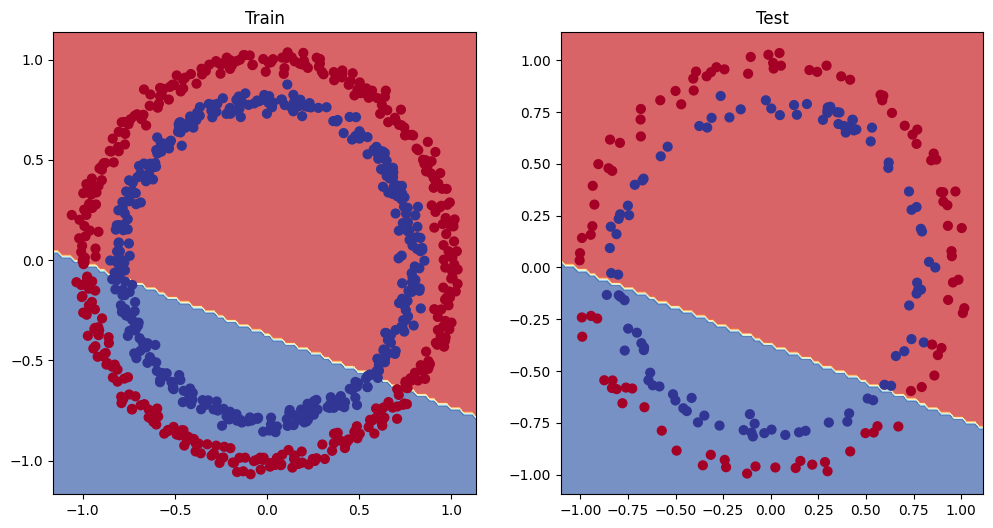

In [56]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, Y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, Y_test)